In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial import ConvexHull, convex_hull_plot_2d 
from source_draft import preprocess as prep

from scipy.stats import entropy
from Bio import SeqIO

In [2]:
plt.rcParams.update({'font.family': 'Helvetica'})
plt.rcParams.update({'font.size': 9})

In [3]:
# Natural sequences
merge_ds = pd.read_excel('data/20210908_natural_with_taxonomy.xls').iloc[:,1:]
SH3 = merge_ds['Sequences']
mmd_nat_coord = np.array(merge_ds[['MMD_z0','MMD_z1','MMD_z2']])

RE_nat = merge_ds['norm_RE']
good_nat = [i for i in range(len(RE_nat)) if RE_nat[i]>.5 and RE_nat[i]<10]
nogood_nat = [i for i in range(len(RE_nat)) if RE_nat[i]<.5 and RE_nat[i]>-10]

In [4]:
# designed sequences
design_sheet = pd.read_excel('data/20210826_design_sheet.xls')
designed_seq = design_sheet['seq'][:11608].tolist()
designed_seq = [i[:16]+i[18:44]+i[45:] for i in designed_seq]
res = design_sheet['RE_norm']

VAE_global,VAE_local,mmd_global,mmd_local,bm = \
np.arange(1,3985),np.arange(3985,4881),np.arange(8621,10621),np.arange(10621,11608),np.arange(4881,8621)

design_mmd = np.array(design_sheet.loc[:11607,['MMD_z0','MMD_z1','MMD_z2']]) # designed mmd coordinates
good_design = np.array([i for i in range(11607) if res[i]>=.5])
nogood_design = np.array([i for i in range(11607) if res[i]<.5])

mmd_all = np.hstack([mmd_global,mmd_local])
good_des_mmd = np.array([i for i in mmd_all if i in good_design])
no_good_des_mmd = np.array([i for i in mmd_all if i not in good_design])

In [5]:
good_nat_mmd_coor = mmd_nat_coord[good_nat,:]
nogood_nat_mmd_coor = mmd_nat_coord[nogood_nat,:]

good_des_mmd_coor= design_mmd[good_des_mmd]
nogood_des_mmd_coor = design_mmd[no_good_des_mmd]

In [6]:
def compute_hull(data, hull):
    ix = np.where(data == hull)[0]
    coord = mmd_nat_coord[ix,:]
    return ConvexHull(coord)

def check_latent_in_hull(z_coord, hull, tolerance = 10**-12):
    decision = all((np.dot(equa[:-1], z_coord) + equa[-1] <= tolerance) for equa in hull.equations)
    return decision

def check_hull_list(l, hull):
    return np.array([check_latent_in_hull(i, hull) for i in l])

def freq_mat(heatmap_list):
    frequence = np.zeros([21, 59])
    listseq = np.array([list(i) for i in heatmap_list])
    for num, i in enumerate('-ACDEFGHIKLMNPQRSTVWY'):
        for j in range(59):
            frequence[num,j] = np.count_nonzero(listseq[:,j]==i)/len(heatmap_list)
    return(frequence)

def compute_entropy(seq):
    return entropy(freq_mat(seq),base=2)

## Functional Sho1 hull

In [7]:
ortho_mmd = good_nat_mmd_coor 

ortho_mmd = ortho_mmd[ortho_mmd[:,0] < -.4, :] # remove outliers
ortho_mmd = ortho_mmd[ortho_mmd[:,1] > 0., :]

ortho_hull = ConvexHull(ortho_mmd)

In [8]:
class_nat = check_hull_list(mmd_nat_coord,ortho_hull)

func_class_nat = check_hull_list(good_nat_mmd_coor,ortho_hull)
nofunc_class_nat = check_hull_list(nogood_nat_mmd_coor,ortho_hull)

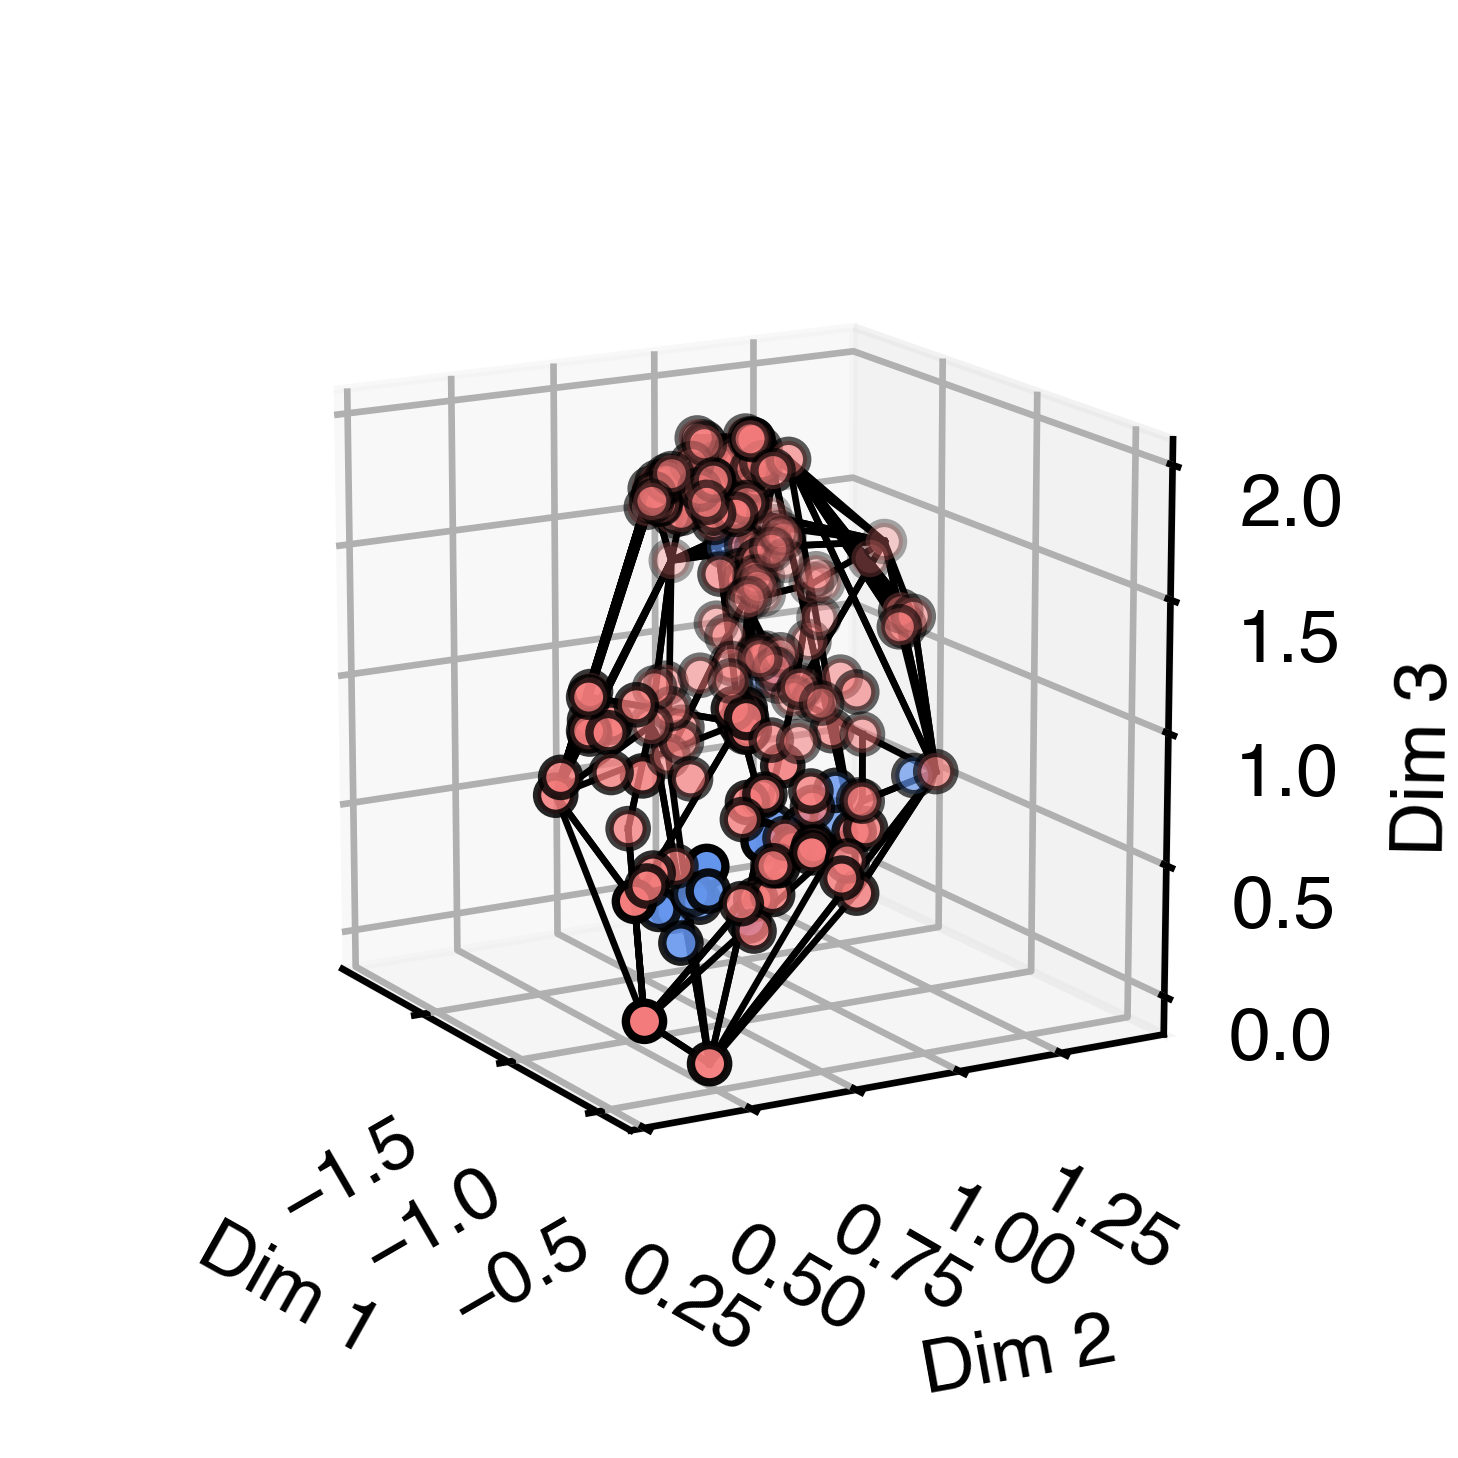

In [9]:
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)

    p = ax.scatter(nogood_nat_mmd_coor[nofunc_class_nat==1,0], nogood_nat_mmd_coor[nofunc_class_nat==1,1], 
                   nogood_nat_mmd_coor[nofunc_class_nat==1,2], c = 'cornflowerblue', edgecolor = 'k', s = 20)
    
    p = ax.scatter(good_nat_mmd_coor[func_class_nat==1,0], good_nat_mmd_coor[func_class_nat==1,1], 
                   good_nat_mmd_coor[func_class_nat==1,2], c='#f47b7b', edgecolor = 'k', s = 20)

    for simplex in ortho_hull.simplices:
        ax.plot(ortho_mmd[simplex, 0], ortho_mmd[simplex, 1],  ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()

In [10]:
fdp = check_hull_list(good_des_mmd_coor,ortho_hull) 
ufdp = check_hull_list(nogood_des_mmd_coor,ortho_hull) 

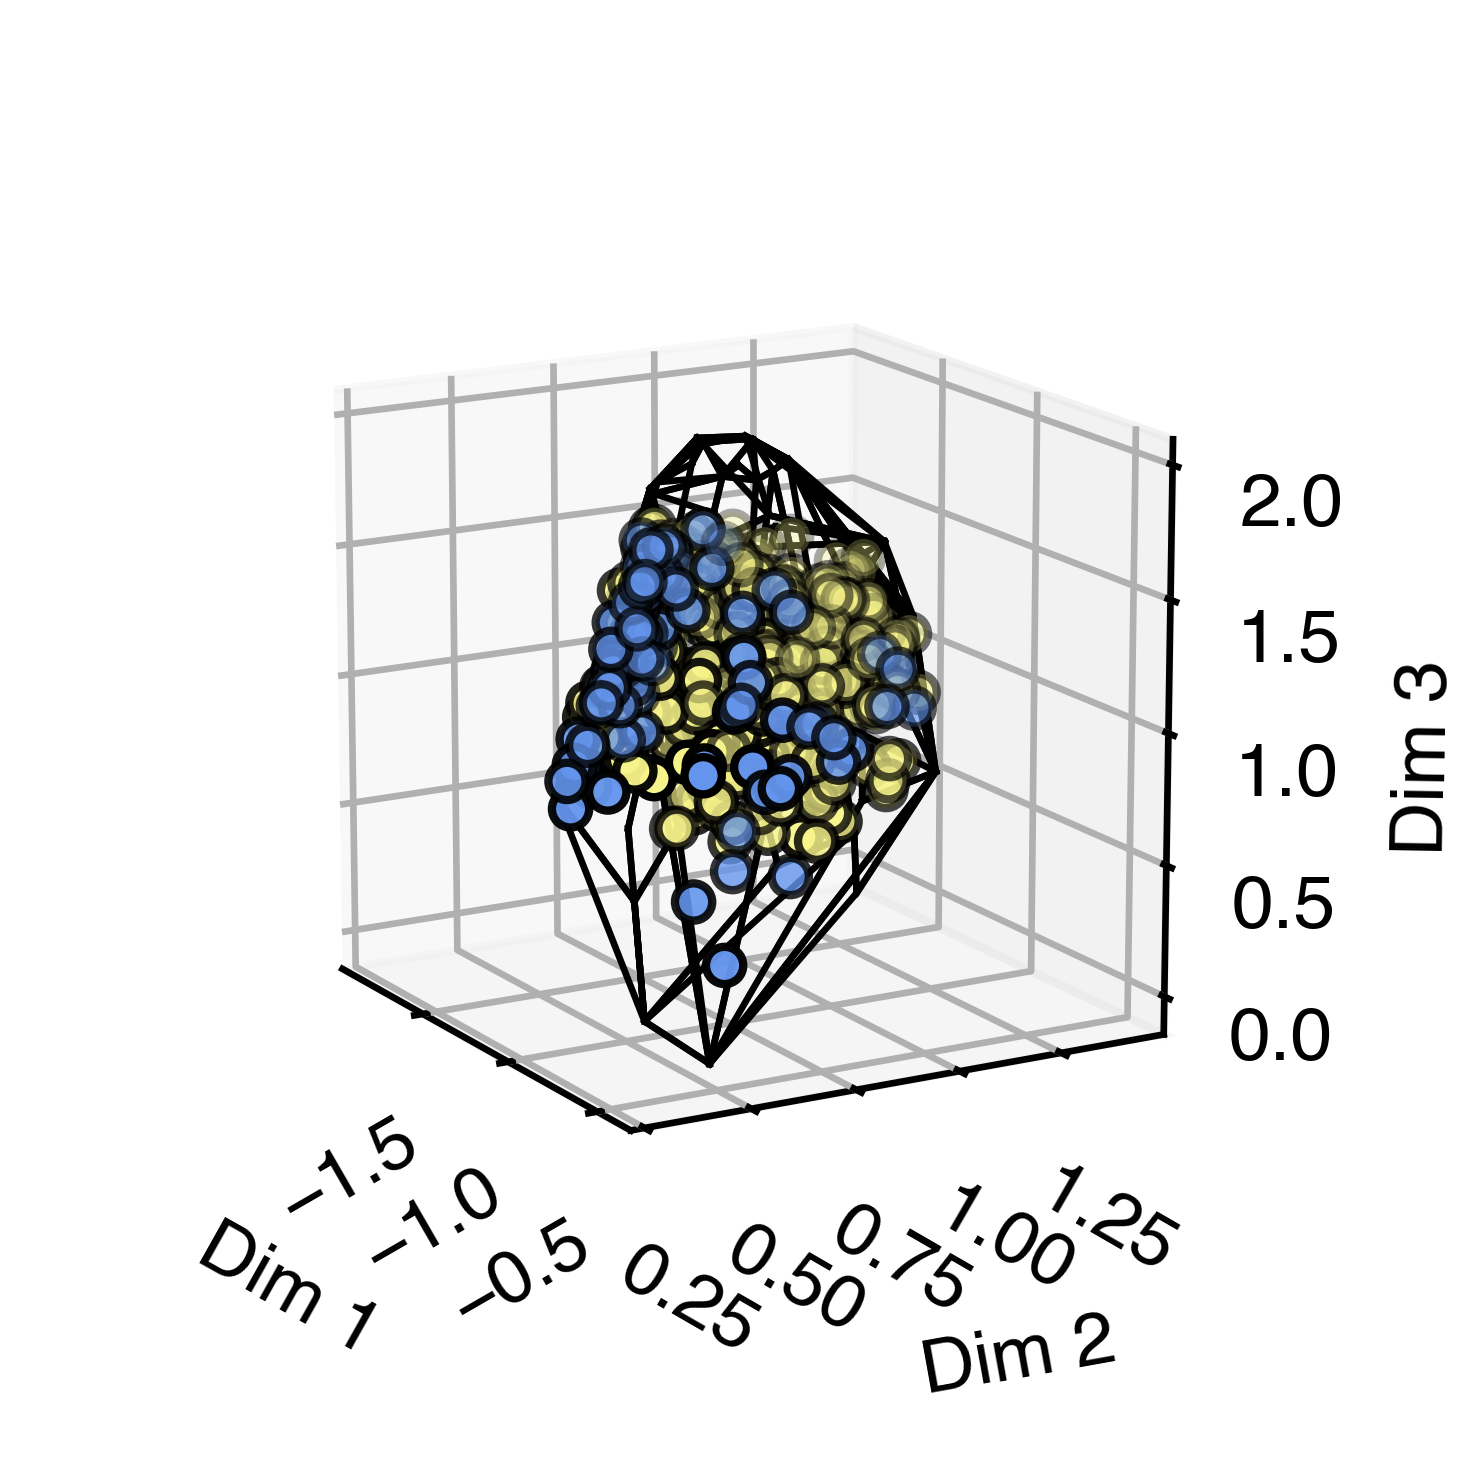

In [63]:
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)
    
    ax.scatter(good_des_mmd_coor[fdp,0], good_des_mmd_coor[fdp,1], good_des_mmd_coor[fdp,2], c='#F7F48B',
    edgecolor = 'k', s = 20)
    ax.scatter(nogood_des_mmd_coor[ufdp,0], nogood_des_mmd_coor[ufdp,1], 
               nogood_des_mmd_coor[ufdp,2], c='cornflowerblue', edgecolor = 'k', s = 20)

    for simplex in ortho_hull.simplices:
        ax.plot(ortho_mmd[simplex, 0], ortho_mmd[simplex, 1],  ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()
plt.savefig('../../VAE_design_paper/Figs_202207/inhull_alldes.svg')

## Volume-ratio

In [9]:
vertices = ortho_mmd[ortho_hull.vertices]
centroid = np.array([-1.1180,0.8458,1.0742])

class convex_hulls:
    def __init__(self, ratio):
        self.vertices = centroid + (vertices - centroid) * ratio
        self.hull = ConvexHull(self.vertices)
    def check(self,coor):
        return check_hull_list(coor, self.hull)

In [10]:
good_all = np.vstack([good_nat_mmd_coor,good_des_mmd_coor])
nogood_all = np.vstack([nogood_nat_mmd_coor,nogood_des_mmd_coor])

In [11]:
hull1 = convex_hulls(1/3)
hull2 = convex_hulls(2/3)
hull3 = convex_hulls(1)
hull4 = convex_hulls(4/3)
hull5 = convex_hulls(5/3)
hull6 = convex_hulls(2)
hull_list = [hull1,hull2,hull3,hull4,hull5,hull6]

In [12]:
good_n = []
nogood_n = []
for i in hull_list:
    good_n.append(np.count_nonzero(i.check(good_all)))
    nogood_n.append(np.count_nonzero(i.check(nogood_all)))

good_shell = [good_n[0]] + [good_n[i]-good_n[i-1] for i in range(1,len(good_n))]
nogood_shell = [nogood_n[0]] + [nogood_n[i]-nogood_n[i-1] for i in range(1,len(nogood_n))]

good_shell = np.array(good_shell)
nogood_shell = np.array(nogood_shell)

ratio = good_shell/(good_shell+nogood_shell)
ratio = np.round(ratio,2)

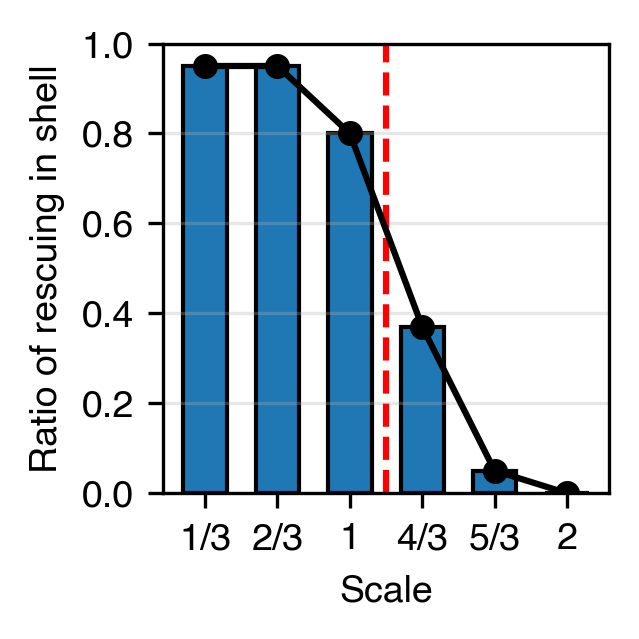

In [65]:
ratio_plot = ['1/3', '2/3', '1', '4/3', '5/3','2']

plt.figure(figsize = [2.2,2.2],dpi=300)
plt.grid(alpha=.3,axis='y')
plt.plot([2.5,2.5],[0,1],'r--')
plt.bar(ratio_plot, ratio,edgecolor='k', width=.6)
plt.plot(ratio_plot, ratio,'ko-', ms=5)
plt.xlabel('Scale')
plt.ylabel('Ratio of rescuing in shell')
plt.ylim([0,1])
plt.tight_layout()
plt.savefig('../../VAE_design_paper/Figs_202207/ratio_hull.svg')
plt.show()

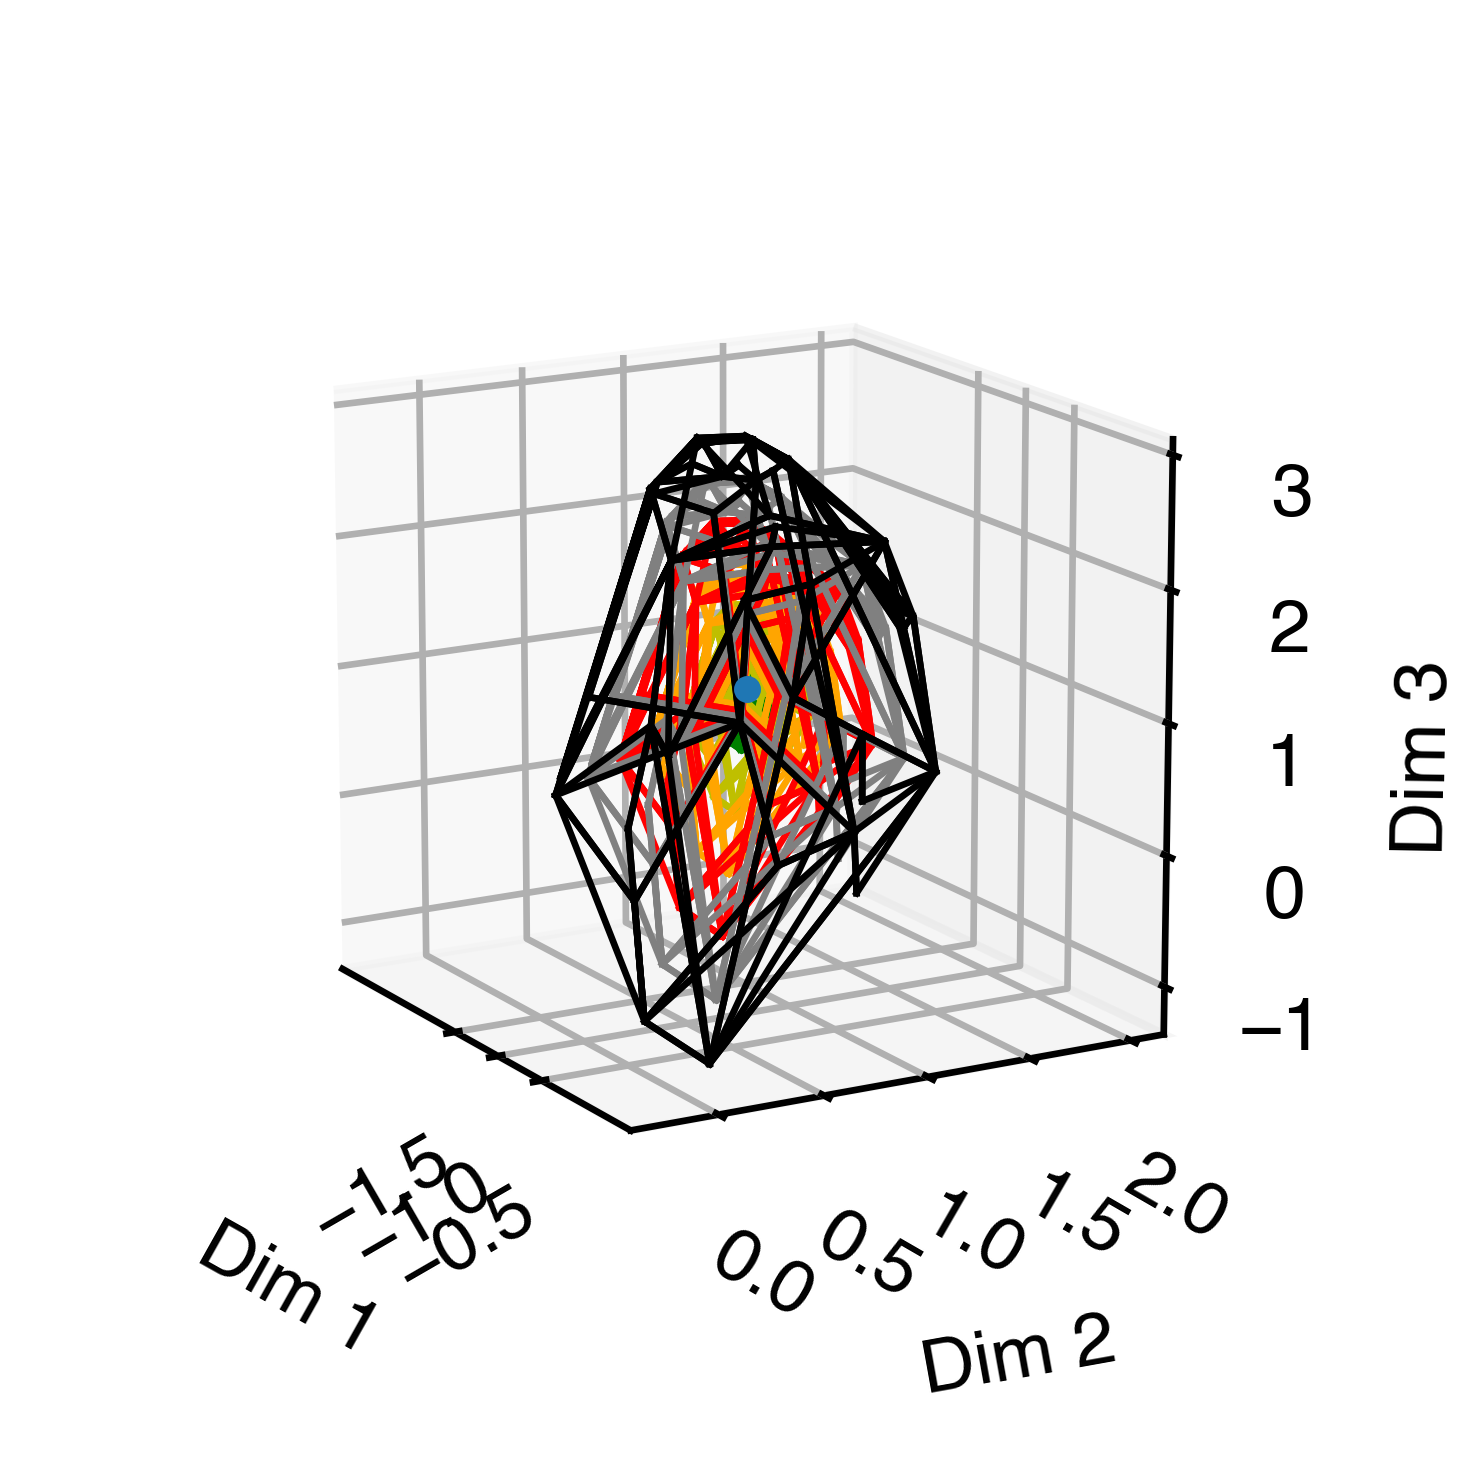

In [24]:
clist = ['g','y','orange','r','gray','k']
for fig_idx, rot_val in zip([0], [-30]):
    fig = plt.figure(figsize = (2.5,2.5),dpi = 600)

    ax = plt.axes(projection="3d")
    ax.view_init(15, rot_val)
    ax.scatter(-1.1180,0.8458,1.0742,s=5)
    
    #p = ax.scatter(des_mmd_coor[:,0], des_mmd_coor[:,1], des_mmd_coor[:,2], s = 5)
    
    for num, h in enumerate(hull_list):
        for simplex in h.hull.simplices:
            ax.plot(h.vertices[simplex, 0], h.vertices[simplex, 1],  h.vertices[simplex, 2],
                    c = clist[num],lw=.8)

    #for simplex in ortho_hull.simplices:
    #    ax.plot(ortho_mmd[simplex, 0], ortho_mmd[simplex, 1],  ortho_mmd[simplex, 2], 'k-',lw=.8)

    ax.set_xlabel('Dim 1', labelpad=9)
    ax.set_ylabel('Dim 2', labelpad=9)
    ax.set_zlabel('Dim 3')
    ax.dist = 12.4
    plt.yticks(rotation=-30)
    plt.xticks([-1.5,-1,-.5],rotation=30)
plt.tight_layout()

## Entropy

In [52]:
mmd_seq=[designed_seq[i] for i in mmd_all]
des_mmd_coor_all = design_mmd[mmd_all] 

class_nat = check_hull_list(mmd_nat_coord,ortho_hull)
class_des_mmd_all = check_hull_list(des_mmd_coor_all,ortho_hull)

inhull_seq=[SH3[i] for i in range(len(class_nat)) if class_nat[i]==1]+\
           [mmd_seq[i] for i in range(len(class_des_mmd_all)) if class_des_mmd_all[i]==1]

func_seq=[SH3[i] for i in good_nat] + [designed_seq[i] for i in good_des_mmd]

all_seq=SH3.tolist()+mmd_seq

In [53]:
entropy_inhull = compute_entropy(inhull_seq)
entropy_func = compute_entropy(func_seq)
entropy_all = compute_entropy(all_seq)

entropy_diff = entropy_all-entropy_inhull
ediff_func = entropy_all-entropy_func

In [58]:
pos_list=np.array([2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61,62,63])

In [61]:
DF=pd.DataFrame(data={'position59_map_to_2VKN':pos_list, 'entropy_diff_hull':entropy_diff, 'entropy_diff_func':ediff_func})
DF.to_csv('/Users/xinran/Documents/VAE_design_paper/annotate_pdb_dS/dS_SH3_functional_positions.csv',
         index=0)

In [46]:
# entropy difference (E_all-E_inhull) within each convex hull

for num, h in enumerate(hull_list):
    class_nat = check_hull_list(mmd_nat_coord,h.hull)
    class_mmd = check_hull_list(des_mmd_coor_all,h.hull)
    inhull_seq=[SH3[i] for i in range(len(class_nat)) if class_nat[i]==1]+\
           [mmd_seq[i] for i in range(len(class_des_mmd_all)) if class_des_mmd_all[i]==1]
    entropy_inhull = compute_entropy(inhull_seq)
    entropy_diff = entropy_all-entropy_inhull
    entropy_diff = np.round(entropy_diff,3)
    #print('entropy_diff_hull%d='%(num+1), end='')
    #print(list(entropy_diff))

In [19]:
sho1='NFIYKAKALYPYDADDAYEISFEQNEILQVSDIEGRWWKARRNGETGIIPSNYVQLIDG'

top_n = 9
top_color_list = []
print('Top %d entropy decreasing positions (all - inhull):\n' %top_n)
for i in entropy_diff.argsort()[-top_n:]:
    print(sho1[i]+str(pos_list[i]), end = ' ')
    top_color_list.append(i)
    
print('\n')
print('Top %d entropy decreasing positions (all - func):\n' %top_n)
for i in ediff_func.argsort()[-top_n:]:
    print(sho1[i]+str(pos_list[i]), end = ' ')

Top 9 entropy decreasing positions (all - inhull):

D62 S24 K42 I52 Y5 D35 G63 G38 S55 

Top 9 entropy decreasing positions (all - func):

S24 D62 K42 I52 Y5 G38 S55 G63 D35 

In [20]:
def R2(x_values,y_values):
    correlation_matrix = np.corrcoef(x_values, y_values)
    correlation_xy = correlation_matrix[0,1]
    return correlation_xy**2

print(R2(entropy_diff,ediff_func))

0.9696402537223133


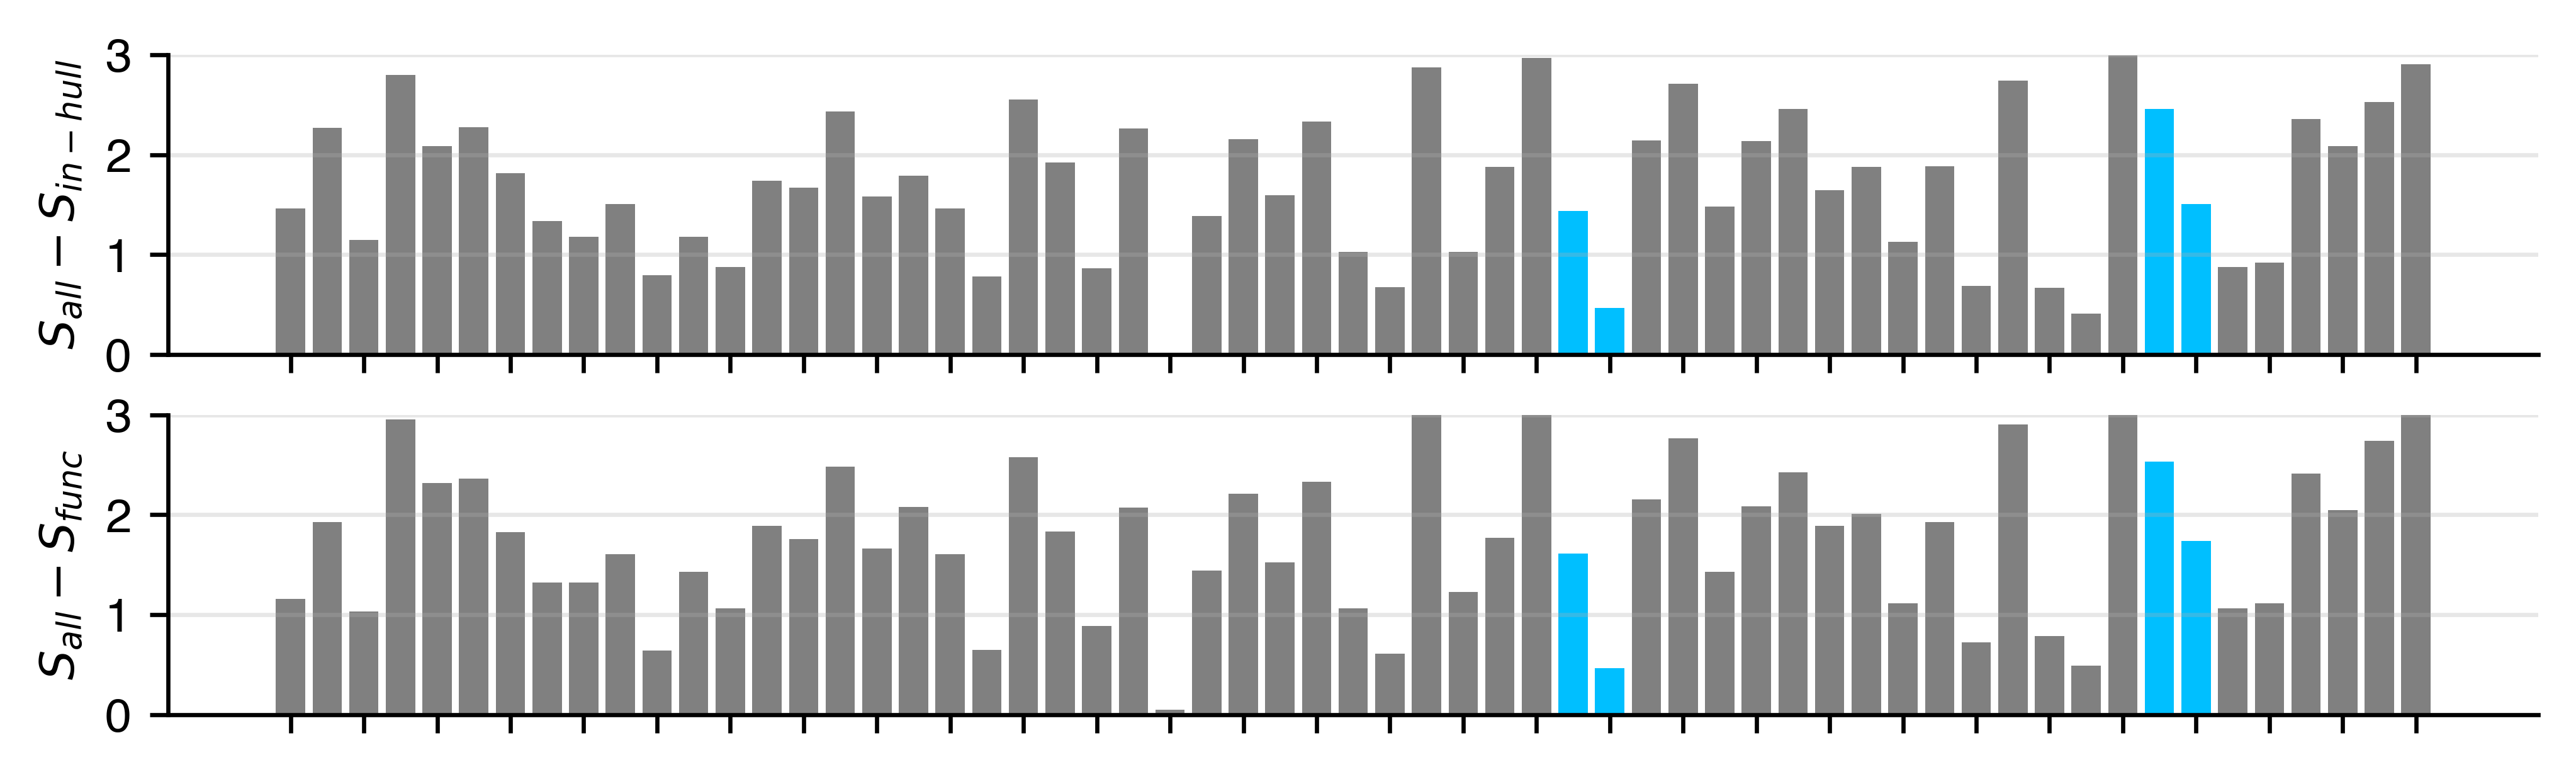

In [62]:
fig, ax = plt.subplots(2,1,figsize = [8.099,2.314],dpi=600)
bars = ax[0].bar(np.arange(59),entropy_diff,color='gray')
bars2 = ax[1].bar(np.arange(59),ediff_func,color='gray')
'''
for i in top_color_list:
    if i <55:
        bars[i].set_facecolor('orange')
        bars2[i].set_facecolor('orange')
'''
for i in [35,36,51,52]:
    bars[i].set_facecolor('deepskyblue')
    bars2[i].set_facecolor('deepskyblue')
    
ax[0].set_ylabel('$S_{all}-S_{in-hull}$')
ax[1].set_ylabel('$S_{all}-S_{func}$')

for i in range(2):
    ax[i].set_xticks(np.arange(0,59,2))
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].yaxis.grid(alpha=.3)
    ax[i].set_ylim([0,3])
    plt.setp(ax[i].get_xticklabels(), visible=False)
plt.savefig('../../VAE_design_paper/Figs_202207/S_hull.svg')
plt.show()

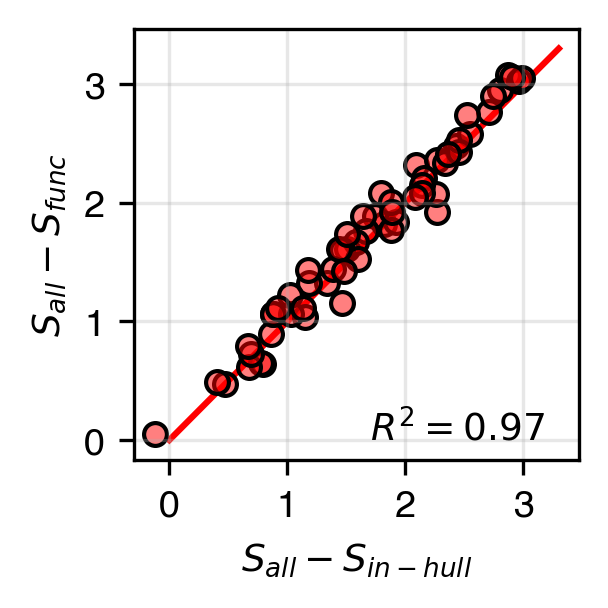

In [29]:
fig,ax = plt.subplots(1,1,figsize=[2.1,2.1],dpi=300)
ax.scatter(entropy_diff,ediff_func, edgecolor='k', facecolor=(1,.0,.0,.5), s = 30)
ax.plot([0,3.3],[0,3.3],'r',zorder=0)
plt.xlabel('$S_{all}-S_{in-hull}$')
plt.ylabel('$S_{all}-S_{func}$')
plt.grid(alpha=.3)
plt.text(1.7,.0,'$R^2 = 0.97$')
plt.yticks([0,1,2,3])
plt.xticks([0,1,2,3])
plt.tight_layout()
plt.savefig('../../VAE_design_paper/Fig4/E_diff.svg')
plt.show()